# Assignment 5

### MACS 30150, Dr. Evans
### Zhou Xing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import lognorm
import pandas as pd
import scipy.integrate as intgr
import numpy.linalg as lin
import scipy.stats as sts 

1(a)

In [2]:
incomes = np.loadtxt('data/incomes.txt')

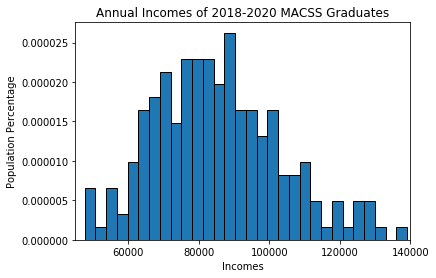

In [3]:
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title("Annual Incomes of 2018-2020 MACSS Graduates")
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([45000, 140000]);

(1b)

In [11]:
def trunc_lognormal_pdf(xvals, mu, sigma, cut_lb=None, cut_ub=None):
    if not cut_ub  and not cut_lb:
        pre_prob = 1.0
    elif not cut_ub and cut_lb :
        pre_prob = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    elif cut_ub and not cut_lb :
        pre_prob = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu))
    elif cut_ub  and cut_lb :
        pre_prob = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu)) - \
                        sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))

    pdf_vals = (1 / pre_prob) * 1 / (xvals * sigma * np.sqrt(2 * np.pi)) * \
                np.exp(- (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2))
    return pdf_vals

In [12]:
# Define a function that computes the two data moments for GMM
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognormal_pdf(x, mu, sigma, cut_lb, cut_ub)
    mean_model= intgr.quad(xfx, cut_lb, cut_ub)[0]
    x2fx = lambda x: (x - mean_model) ** 2 * trunc_lognormal_pdf(x, mu, sigma, cut_lb, cut_ub)
    var_model= intgr.quad(x2fx, cut_lb, cut_ub)[0]
    std_model = np.sqrt(var_model)
    return mean_model, std_model


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moments_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moments_model = np.array([[mean_model], [std_model]])
    
    if simple:
        err_vec = moments_model - moments_data
    else:
        err_vec = (moments_model - moments_data) / moments_data
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cub_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [13]:
# Estimate the parameters of the lognormal dist. by GMM
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
cut_lb = 0.0
cut_ub = 150000.0
W_hat = np.eye(2)  # Generate the identity matrix
gmm_args = (incomes, cut_lb, cut_ub, W_hat)
results = opt.minimize(criterion, params_init, args=gmm_args, tol=1e-14, 
                       method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x

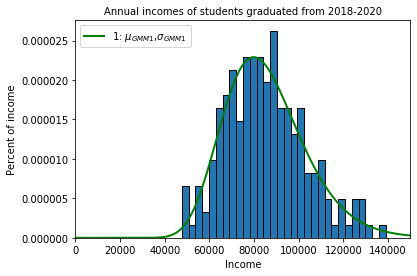

In [14]:
num_bins = 30
plt.hist(incomes, num_bins,edgecolor='k',density=True)
plt.title('Annual incomes of students graduated from 2018-2020', fontsize=10)
plt.xlabel(r'Income')
plt.ylabel('Percent of income')
plt.xlim([1e-9, 150000])  # This gives the xmin and xmax to be plotted"

dist_pts = np.linspace(1e-9, 150000, 200000)
mu_1 = mu_GMM1
sig_1 = sig_GMM1
plt.plot(dist_pts, trunc_lognormal_pdf(dist_pts, mu_1, sig_1),
         linewidth=2, color='g', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

In [15]:
# Report the estimate results
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, cut_lb, cut_ub)
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, cut_lb, cut_ub, simple=False).reshape(2, )

print("GMM Estimate Params")
print("mu_GMM: ", mu_GMM1)
print("sigma_GMM: ", sig_GMM1)

print("\nData Moments")
print("Data Mean: ", mean_data)
print("Data S.T.D.: ", std_data)

print("\nModel Moments")
print("Model Mean: ", mean_model)
print("Model S.T.D. :", std_model)

print("\nSimple Difference")
print("Mean Difference: ", abs(mean_data - mean_model))
print("S.T.D. Difference: ", abs(std_data - std_model))

print("\nPercentage Difference")
print("Mean Difference: ", abs((mean_data - mean_model) / mean_data))
print("S.T.D. Difference: ", abs((std_data - std_model) / std_model))

print("\nValue of Criterion Function: ", results.fun)

GMM Estimate Params
mu_GMM:  11.333599613401049
sigma_GMM:  0.21325529509280278

Data Moments
Data Mean:  85276.82360625811
Data S.T.D.:  17992.542128046523

Model Moments
Model Mean:  85276.82405854714
Model S.T.D. : 17992.541683008654

Simple Difference
Mean Difference:  0.00045228902308735996
S.T.D. Difference:  0.0004450378692126833

Percentage Difference
Mean Difference:  5.3037742725465255e-09
S.T.D. Difference:  2.4734574861813827e-08

Value of Criterion Function:  [[6.39929185e-16]]


(c)

In [17]:
# Define a function that computes the R * N matrix of error from each observations for each moment
def get_Err_mat_2(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    mean_data, std_data = data_moments(xvals)
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = mean_model - xvals
        Err_mat[1, :] = std_model - np.sqrt((mean_data - xvals) ** 2)
    else:
        Err_mat[0, :] = (mean_model - xvals) / xvals
        Err_mat[1, :] = (std_model - np.sqrt((mean_data - xvals) ** 2)) / (np.sqrt((mean_data - xvals) ** 2))
    return Err_mat

In [18]:
# Calculate the new estimate of the var.-cov. matrix
err_mat = get_Err_mat_2(incomes, mu_GMM1, sig_GMM1, cut_lb, cut_ub, simple=False)
N = incomes.shape[0]
VCV2 = 1 / N  * err_mat @ err_mat.T
print("The estimate for the var.-cov. matrix = \n", VCV2)

The estimate for the var.-cov. matrix = 
 [[5.30804062e-02 6.34981099e-03]
 [6.34981099e-03 1.32826952e+04]]


In [19]:
# Calculate the new optimal weighing matrix
W_hat2 = lin.inv(VCV2)
print("The two-step estimator for the optimal weighting matrix = \n", W_hat2)

The two-step estimator for the optimal weighting matrix = 
 [[ 1.88393445e+01 -9.00617491e-06]
 [-9.00617491e-06  7.52859295e-05]]


In [20]:
# Estimate the parameters of the lognormal dist. by two-step GMM
params_init = np.array([mu_GMM1, sig_GMM1])
cut_lb = 0.0
cut_ub = 150000.0
gmm_args2 = (incomes, cut_lb, cut_ub, W_hat2)
results2 = opt.minimize(criterion, params_init, args=gmm_args2, tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x

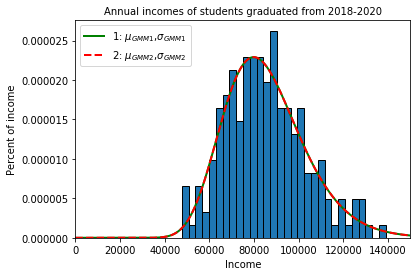

In [24]:
num_bins = 30
plt.hist(incomes, num_bins,edgecolor='k',density=True)
plt.title('Annual incomes of students graduated from 2018-2020', fontsize=10)
plt.xlabel(r'Income')
plt.ylabel('Percent of income')
plt.xlim([1e-9, 150000])  # This gives the xmin and xmax to be plotted"

dist_pts = np.linspace(1e-9, 150000, 200000)
mu_1 = mu_GMM1
sig_1 = sig_GMM1
plt.plot(dist_pts, trunc_lognormal_pdf(dist_pts, mu_1, sig_1),
         linewidth=2, color='g', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

dist_pts = np.linspace(1e-9, 150000, 200000)
mu_2 = mu_GMM2
sig_2 = sig_GMM2
plt.plot(dist_pts, trunc_lognormal_pdf(dist_pts, mu_2, sig_2 ),
         linewidth=2, color='r', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$',ls ='--')
plt.legend(loc='upper left')

In [25]:
# Report the estimate results
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2, cut_lb, cut_ub)
err2 = err_vec(incomes, mu_GMM2, sig_GMM2, cut_lb, cut_ub, simple=False).reshape(2, )

print("GMM Estimate Params")
print("mu_GMM: ", mu_GMM2)
print("sigma_GMM: ", sig_GMM2)

print("\nData Moments")
print("Data Mean: ", mean_data)
print("Data S.T.D.: ", std_data)

print("\nModel Moments")
print("Model Mean: ", mean_model)
print("Model S.T.D. :", std_model)

print("\nSimple Difference")
print("Mean Difference: ", abs(mean_data - mean_model))
print("S.T.D. Difference: ", abs(std_data - std_model))

print("\nPercentage Difference")
print("Mean Difference: ", abs((mean_data - mean_model) / mean_data))
print("S.T.D. Difference: ", abs((std_data - std_model) / std_model))

print("\nValue of Criterion Function: ", results2.fun)

GMM Estimate Params
mu_GMM:  11.333599603769782
sigma_GMM:  0.21325529448575314

Data Moments
Data Mean:  85276.82360625811
Data S.T.D.:  17992.542128046523

Model Moments
Model Mean:  85276.82325897942
Model S.T.D. : 17992.541508808466

Simple Difference
Mean Difference:  0.00034727869206108153
S.T.D. Difference:  0.0006192380569700617

Percentage Difference
Mean Difference:  4.072368990483789e-09
S.T.D. Difference:  3.441637506668562e-08

Value of Criterion Function:  [[3.12521903e-16]]


# (d)

In [26]:
# Define a function that computes the three data moments for GMM
def data_moments3(xvals):
    N = xvals.shape[0]
    bpct_1_dat = xvals[xvals < 75000.0].shape[0] / N
    bpct_2_dat = xvals[(xvals >= 75000.0) & (xvals < 100000.0)].shape[0] / N
    bpct_3_dat = xvals[xvals > 100000.0].shape[0] / N
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [27]:
# Define a function that computes the three model moments for GMM
def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognormal_pdf(x, mu, sigma, cut_lb, cut_ub)
    bpct_1_mod, bp_1_err = intgr.quad(xfx, 0.0, 75000.0)
    bpct_2_mod, bp_2_err = intgr.quad(xfx, 75000.0, 100000.0)
    bpct_3_mod, bp_3_err = intgr.quad(xfx, 100000.0, 150000.0)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [28]:
# Define the moment error function
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_mod = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_mod - moms_data
    else:
        err_vec = (moms_mod - moms_data) / moms_data
    return err_vec

In [29]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cub_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [30]:
# Estimate the params by 3-moment GMM
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
cut_lb = 0.0
cut_ub = 150000.0
W_hat = np.eye(3)  # Generate the identity matrix
gmm_args3 = (incomes, cut_lb, cut_ub, W_hat)
results3_1 = opt.minimize(criterion3, params_init, args=gmm_args3, \
                        tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_1, sig_GMM3_1 = results3_1.x
print("mu_GMM3_1 = ", mu_GMM3_1)
print("sig_GMM3_1 = ", sig_GMM3_1)
results3_1

mu_GMM3_1 =  11.336705181100031
sig_GMM3_1 =  0.21151351584300565


      fun: array([[1.82841985e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.72499409e-07, 7.61405060e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 153
      nit: 22
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

In [31]:
# Report the estimate results
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(incomes)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub)


print("GMM Estimate Params")
print("mu_GMM: ", mu_GMM3_1)
print("sigma_GMM: ", sig_GMM3_1)

print("\nData Moments")
print("Data Percentile: ", data_moments3(incomes))

print("\nModel Moments")
print("Model Percentile: ", model_moments3(mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub))

print("\nSimple Difference")
print("Percentile Difference: ", abs(np.array(model_moments3(mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub)) \
                               - np.array(data_moments3(incomes))))

print("\nPercentage Difference")
print("Percentile Difference: ", abs(np.array(model_moments3(mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub)) \
                               - np.array(data_moments3(incomes))) / np.array(data_moments3(incomes)))
print("\nValue of Criterion Function: ", results3_1.fun)

GMM Estimate Params
mu_GMM:  11.336705181100031
sigma_GMM:  0.21151351584300565

Data Moments
Data Percentile:  (0.3, 0.5, 0.2)

Model Moments
Model Percentile:  (0.3000000012519241, 0.5000000068113886, 0.19999999193668755)

Simple Difference
Percentile Difference:  [1.25192412e-09 6.81138856e-09 8.06331246e-09]

Percentage Difference
Percentile Difference:  [4.17308040e-09 1.36227771e-08 4.03165623e-08]

Value of Criterion Function:  [[1.82841985e-15]]


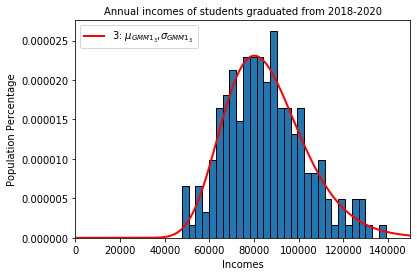

In [49]:
# Plot the estimated lognormal PDF against the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title('Annual incomes of students graduated from 2018-2020', fontsize=10)
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([1e-10, 150000])

dist_incomes = np.linspace(1e-10, 150000, 5000)
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM3_1, sig_GMM3_1, 0, 150000), \
         lw=2, color="r", label='3: $\mu_{GMM1_3}$,$\sigma_{GMM1_3}$')
         
plt.legend(loc="upper left");

#### (e) Three moments, two-step estimator for the optimal weighting matrix

In [33]:
# Define a function that computes the R * N matrix of error from each observations for each moment
def get_Err_mat_3(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(xvals)
    err_mat3 = np.zeros((R, N))
    income_group1 = xvals < 75000.0
    income_group2 = (xvals >= 75000.0) & (xvals < 100000.0)
    income_group3 = xvals >= 100000.0
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        err_mat3[0, :] = income_group1 - bpct_1_mod
        err_mat3[1, :] = income_group2 - bpct_2_mod
        err_mat3[2, :] = income_group3 - bpct_3_mod
    else:
        err_mat3[0, :] = (income_group1 - bpct_1_mod) / income_group1 
        err_mat3[1, :] = (income_group2 - bpct_2_mod) / income_group2
        err_mat3[2, :] = (income_group3 - bpct_3_mod) / income_group3
    return err_mat3

In [34]:
# Calculate the new estimate of the var.-cov. matrix
err_mat3 = get_Err_mat_3(incomes, mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub, simple=True)
N = incomes.shape[0]
VCV3_2 = 1 / N  * err_mat3 @ err_mat3.T
print("The estimate for the var.-cov. matrix = \n", VCV3_2)

The estimate for the var.-cov. matrix = 
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]


In [35]:
# Calculate the new optimal weighing matrix
W_hat3_2 = lin.pinv(VCV3_2)
print("The two-step estimator for the optimal weighting matrix = \n", W_hat3_2)

The two-step estimator for the optimal weighting matrix = 
 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [36]:
# Estimate the params by 3-moment two-step GMM
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
cut_lb = 0.0
cut_ub = 150000.0
gmm_args3_2 = (incomes, cut_lb, cut_ub, W_hat3_2)
results3_2 = opt.minimize(criterion3, params_init, args=gmm_args3_2, \
                          tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_2, sig_GMM3_2 = results3_2.x
print("mu_GMM3_2 = ", mu_GMM3_2)
print("sig_GMM3_2 = ", sig_GMM3_2)
results3_2

mu_GMM3_2 =  11.33670517977796
sig_GMM3_2 =  0.21151351746070246


      fun: array([[7.98219642e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.26797347e-08, 1.05845364e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 14
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

In [37]:
# Report the estimate results
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(incomes)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub)


print("GMM Estimate Params")
print("mu_GMM: ", mu_GMM3_2)
print("sigma_GMM: ", sig_GMM3_2)

print("\nData Moments")
print("Data Percentile: ", data_moments3(incomes))

print("\nModel Moments")
print("Model Percentile: ", model_moments3(mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub))

print("\nSimple Difference")
print("Percentile Difference: ", abs(np.array(model_moments3(mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub)) \
                               - np.array(data_moments3(incomes))))

print("\nPercentage Difference")
print("Percentile Difference: ", abs(np.array(model_moments3(mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub)) \
                               - np.array(data_moments3(incomes))) / np.array(data_moments3(incomes)))
print("\nValue of Criterion Function: ", results3_2.fun)

GMM Estimate Params
mu_GMM:  11.33670517977796
sigma_GMM:  0.21151351746070246

Data Moments
Data Percentile:  (0.3, 0.5, 0.2)

Model Moments
Model Percentile:  (0.30000000487279566, 0.5000000032639927, 0.19999999186321202)

Simple Difference
Percentile Difference:  [4.87279567e-09 3.26399274e-09 8.13678799e-09]

Percentage Difference
Percentile Difference:  [1.62426522e-08 6.52798549e-09 4.06839400e-08]

Value of Criterion Function:  [[7.98219642e-15]]


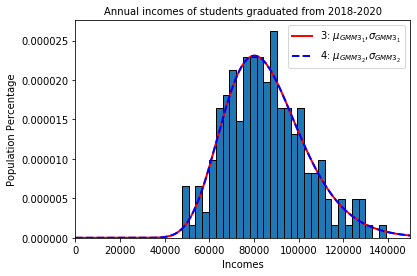

In [51]:
# Plot the estimated lognormal PDF against the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title('Annual incomes of students graduated from 2018-2020', fontsize=10)
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([1e-10, 150000])

dist_incomes = np.linspace(1e-10, 150000, 5000)
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM3_1, sig_GMM3_1, 0, 150000), \
         lw=2, color="r", label='3: $\mu_{GMM3_1}$,$\sigma_{GMM3_1}$')
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM3_2, sig_GMM3_2, 0, 150000), \
         lw=2, ls="--", color="b", label='4: $\mu_{GMM3_2}$,$\sigma_{GMM3_2}$')

plt.legend(loc="best");

**As before, the four data moments and the four model moments are very close up to the 8th decimal points.**

**And the four-moment two-step GMM estimation has very similar results with the previous four-moment GMM estimation.**

#### (f)

In [39]:
method = ["2 Moments with Identity",
          "2 Moments with 2-step",
          "3 Moments with Identity",
          "3 Moments with 2-step"]
mu_list = [mu_GMM1, mu_GMM2, mu_GMM3_1, mu_GMM3_2]
sig_list = [sig_GMM1, sig_GMM2, sig_GMM3_1, sig_GMM3_2]
val_list = [results.fun, results2.fun, results3_1.fun, results3_2.fun]

pd.DataFrame(index=method, data={"mu": mu_list,
                                 "sig": sig_list,
                                 "Criterion Function Value": val_list}).astype(float)

,mu,sig,Criterion Function Value
2 Moments with Identity,11.333600,0.213255,6.399292e-16
2 Moments with 2-step,11.333600,0.213255,3.125219e-16
3 Moments with Identity,11.336705,0.211514,1.828420e-15
3 Moments with 2-step,11.336705,0.211514,7.982196e-15


**Generally speaking, the GMM estimations are very similar to each other up to the 15th decimal. The 2-step GMM model using 2 moments, i.e. model (c) fits the data best because it has the smallest value of the criterion function.**

### Question 2

#### (a)

In [40]:
# Load the sick data as dataframe
df = pd.read_csv("data/sick.txt").astype(float)
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [41]:
# Define the moment error function
def get_err_vec(df, b0, b1, b2, b3):
    err_vec = df["sick"] - b0 - b1 * df["age"] - b2 * df["children"] - b3 * df["avgtemp_winter"]
    return err_vec

In [42]:
# Define the criterion function
def criterion2(params, *args):
    b0, b1, b2, b3 = params
    df, W = args
    err = get_err_vec(df, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

In [43]:
# Perform the GMM estimation
b0_init = 0.25
b1_init = 0.01
b2_init = 0.4
b3_init = -0.01
params_init2 = np.array([b0_init, b1_init, b2_init, b3_init])
W2 = np.eye(200)  # Generate the identity matrix
gmm_args2 = (df, W2)
results2 = opt.minimize(criterion2, params_init2, args=gmm_args2, method="L-BFGS-B", tol=1e-14)
b0_gmm, b1_gmm, b2_gmm, b3_gmm = results2.x
crit_val2 = results2.fun
print("GMM Estimation Result: \n")
for i, b in zip(range(4), results2.x):
    print("beta_{}".format(i),"\t", b)
print("\nGMM Criterion Function Value: ", crit_val2)

GMM Estimation Result: 

beta_0 	 0.25164429050231746
beta_1 	 0.01293350811080286
beta_2 	 0.40050074879477193
beta_3 	 -0.009991722818624333

GMM Criterion Function Value:  0.0018212897399312498
